## Tutorial of indirect objective identification with DAS

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/frankaging/align-transformers/blob/main/tutorials/Indirect%20object%20identification%20(IOI)%20circuit%20with%20DAS.ipynb)

In [1]:
__author__ = "Zhengxuan Wu"
__version__ = "12/26/2023"

### Overview

This tutorial tries to reproduce some of the key results in [this paper](https://arxiv.org/pdf/2311.17030.pdf) using this library. It tries to localize name position information with additional streams beside `mlp_activation` as well as `block_output`. We can sort of seeing where information emerges throughout the network.

### Set-up

In [2]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import transformers
    import sys
    sys.path.append("align-transformers/")
except ModuleNotFoundError:
    !git clone https://github.com/frankaging/align-transformers.git
    !pip install -r align-transformers/requirements.txt
    import sys
    sys.path.append("align-transformers/")

In [3]:
import sys
sys.path.append("../..")

import pandas as pd
from tutorial_ioi_utils import *
from models.basic_utils import embed_to_distrib, top_vals, format_token
from models.configuration_alignable_model import AlignableRepresentationConfig, AlignableConfig
from models.alignable_base import AlignableModel
from models.interventions import LowRankRotatedSpaceIntervention, SkipIntervention
from models.gpt2.modelings_alignable_gpt2 import create_gpt2_lm

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
from plotnine import ggplot, geom_tile, aes, facet_wrap, theme, element_text, \
                     geom_bar, geom_hline, scale_y_log10, scale_y_reverse, scale_fill_cmap, geom_text, \
                     scale_fill_gradient, geom_point, geom_line, theme_minimal, ylim, ggtitle, ggsave

def single_d_low_rank_das_position_config(
    model_type, intervention_type, layer, alignable_interventions_type,
    alignable_low_rank_dimension=1, num_unit=1, head_level=False
):
    alignable_config = AlignableConfig(
        alignable_model_type=model_type,
        alignable_representations=[
            AlignableRepresentationConfig(
                layer,             # layer
                intervention_type, # intervention type
                "pos" if not head_level else "h.pos",
                num_unit,
                alignable_low_rank_dimension=alignable_low_rank_dimension, # a single das direction
            ),
        ],
        alignable_interventions_type=alignable_interventions_type,
    )
    return alignable_config

criterion = torch.nn.CrossEntropyLoss()
# You can define your custom compute_metrics function.
def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        actual_test_labels = eval_label
        pred_test_labels = torch.argmax(eval_pred[:, -1], dim=-1)
        correct_labels = (actual_test_labels==pred_test_labels)
        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
    accuracy = round(correct_count/total_count, 2)
    return {"accuracy" : accuracy}

def calculate_loss(logits, labels):
    shift_logits = logits[..., -1, :].contiguous()
    shift_labels = labels.contiguous()
    # Flatten the tokens
    shift_logits = shift_logits
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = criterion(shift_logits, shift_labels)

    return loss

def find_name_position_at(
    positions, layers, stream, heads=None, 
    alignable_low_rank_dimension=1,
    debug=False
):
    
    across_positions = True if isinstance(positions[0], list) else False
    
    data = []

    batch_size = 20
    eval_every = 5
    initial_lr = 0.01
    n_epochs = 10
    aligning_stream = stream

    for aligning_pos in positions:
        for aligning_layer in layers:
            if debug:
                print(
                    f"finding name position at: pos->{aligning_pos}, "
                    f"layers->{aligning_layer}, stream->{stream}"
                )
            if heads is not None:
                alignable_config = single_d_low_rank_das_position_config(
                    type(gpt2), aligning_stream, aligning_layer, LowRankRotatedSpaceIntervention,
                    alignable_low_rank_dimension=alignable_low_rank_dimension, num_unit=len(heads), head_level=True
                )
            else:
                if across_positions:
                    alignable_config = single_d_low_rank_das_position_config(
                        type(gpt2), aligning_stream, aligning_layer, LowRankRotatedSpaceIntervention,
                        alignable_low_rank_dimension=alignable_low_rank_dimension, num_unit=len(positions[0]),
                    )
                else:
                    alignable_config = single_d_low_rank_das_position_config(
                        type(gpt2), aligning_stream, aligning_layer, LowRankRotatedSpaceIntervention,
                        alignable_low_rank_dimension=alignable_low_rank_dimension
                    )
            alignable = AlignableModel(alignable_config, gpt2)
            alignable.set_device("cuda")
            alignable.disable_model_gradients()
            
            optimizer = torch.optim.Adam(alignable.get_trainable_parameters(), lr=initial_lr)
            scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, end_factor=0.1, total_iters=n_epochs
            )

            total_step = 0
            for epoch in range(n_epochs):
                torch.cuda.empty_cache()
                for batch_dataset in D_train.batches(batch_size=batch_size):
                    # prepare base
                    base_inputs = batch_dataset.base.tokens
                    b_s = base_inputs["input_ids"].shape[0]
                    for k, v in base_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            base_inputs[k] = v.to(gpt2.device)
                    # prepare source
                    source_inputs = batch_dataset.source.tokens
                    for k, v in source_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            source_inputs[k] = v.to(gpt2.device)
                    # prepare label
                    labels = batch_dataset.patched_answer_tokens[:,0].to(gpt2.device)

                    assert all(x==18 for x in batch_dataset.base.lengths)
                    assert all(x==18 for x in batch_dataset.source.lengths)
                    
                    if heads is not None:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": (
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ], 
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ]
                            )}
                        )
                    else:
                        if across_positions:
                            _, counterfactual_outputs = alignable(
                                {"input_ids": base_inputs["input_ids"]},
                                [{"input_ids": source_inputs["input_ids"]}],
                                {"sources->base": ([[aligning_pos]*b_s], [[aligning_pos]*b_s])}
                            ) 
                        else:
                            _, counterfactual_outputs = alignable(
                                {"input_ids": base_inputs["input_ids"]},
                                [{"input_ids": source_inputs["input_ids"]}],
                                {"sources->base": ([[[aligning_pos]]*b_s], [[[aligning_pos]]*b_s])}
                            )

                    eval_metrics = compute_metrics([counterfactual_outputs.logits], [labels])
                    loss = calculate_loss(counterfactual_outputs.logits, labels)
                    loss_str = round(loss.item(), 2)
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    alignable.set_zero_grad()
                    total_step += 1

            # eval
            eval_labels = []
            eval_preds = []
            with torch.no_grad():
                torch.cuda.empty_cache()
                for batch_dataset in D_test.batches(batch_size=batch_size):
                    # prepare base
                    base_inputs = batch_dataset.base.tokens
                    b_s = base_inputs["input_ids"].shape[0]
                    for k, v in base_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            base_inputs[k] = v.to(gpt2.device)
                    # prepare source
                    source_inputs = batch_dataset.source.tokens
                    for k, v in source_inputs.items():
                        if v is not None and isinstance(v, torch.Tensor):
                            source_inputs[k] = v.to(gpt2.device)
                    # prepare label
                    labels = batch_dataset.patched_answer_tokens[:,0].to(gpt2.device)

                    assert all(x==18 for x in batch_dataset.base.lengths)
                    assert all(x==18 for x in batch_dataset.source.lengths)

                    if heads is not None:
                        _, counterfactual_outputs = alignable(
                            {"input_ids": base_inputs["input_ids"]},
                            [{"input_ids": source_inputs["input_ids"]}],
                            {"sources->base": (
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ], 
                                [
                                    [[heads]*b_s, [[aligning_pos]]*b_s]
                                ]
                            )}
                        )
                    else:
                        if across_positions:
                            _, counterfactual_outputs = alignable(
                                {"input_ids": base_inputs["input_ids"]},
                                [{"input_ids": source_inputs["input_ids"]}],
                                {"sources->base": ([[aligning_pos]*b_s], [[aligning_pos]*b_s])}
                            ) 
                        else:
                            _, counterfactual_outputs = alignable(
                                {"input_ids": base_inputs["input_ids"]},
                                [{"input_ids": source_inputs["input_ids"]}],
                                {"sources->base": ([[[aligning_pos]]*b_s], [[[aligning_pos]]*b_s])}
                            )
                    eval_labels += [labels]
                    eval_preds += [counterfactual_outputs.logits]
            eval_metrics = compute_metrics(eval_preds, eval_labels)
            if heads is not None:
                heads_str = ",".join([str(h) for h in heads])
                data.append({
                    "pos":aligning_pos,
                    "layer":aligning_layer,
                    "acc":eval_metrics['accuracy'],
                    "stream":f"{stream}_{heads_str}"
                })
            else:
                data.append({
                    "pos":aligning_pos,
                    "layer":aligning_layer,
                    "acc":eval_metrics['accuracy'],
                    "stream":stream
                })
    return data

[2023-12-27 00:01:34,251] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


### Load dataset

Dataset creation is copied from [this repo](https://github.com/amakelov/activation-patching-illusion).

In [4]:
transformers.set_seed(42)

config, tokenizer, gpt2 = create_gpt2_lm(cache_dir="../../../.huggingface_cache")
_ = gpt2.eval().to("cuda")

D_train = train_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['ABB', 'BAB'],
    source_patterns=['ABB', 'BAB'],
    labels='position',
    samples_per_combination=50,
)
D_test = test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['ABB',],
    source_patterns=['BAB'],
    labels='position',
    samples_per_combination=50,
) + test_distribution.sample_das(
    tokenizer=tokenizer,
    base_patterns=['BAB',],
    source_patterns=['ABB'],
    labels='position',
    samples_per_combination=50,
)

loaded model


### Factual recall

In [5]:
total_count = 0
correct_count = 0
with torch.no_grad():
    for batch_dataset in D_train.batches(batch_size=30):
        inputs = batch_dataset.base.tokens

        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(gpt2.device)
        labels = batch_dataset.base.answer_tokens[:,0].to(gpt2.device)

        outputs = gpt2(**inputs)

        pred_labels = outputs.logits.argmax(dim=-1)[:,-1]
        correct_labels = (labels==pred_labels)

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count/total_count, 2)
print(f"gpt-2 IOI task accuracy: {current_acc}")

gpt-2 IOI task accuracy: 0.96


### Localizing in the main residual stream

In [ ]:
block_out_data = find_name_position_at(
    [13, 14, 15, 16, 17], [i for i in range(12)], "block_output", debug=True)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/block_out_plot.pdf


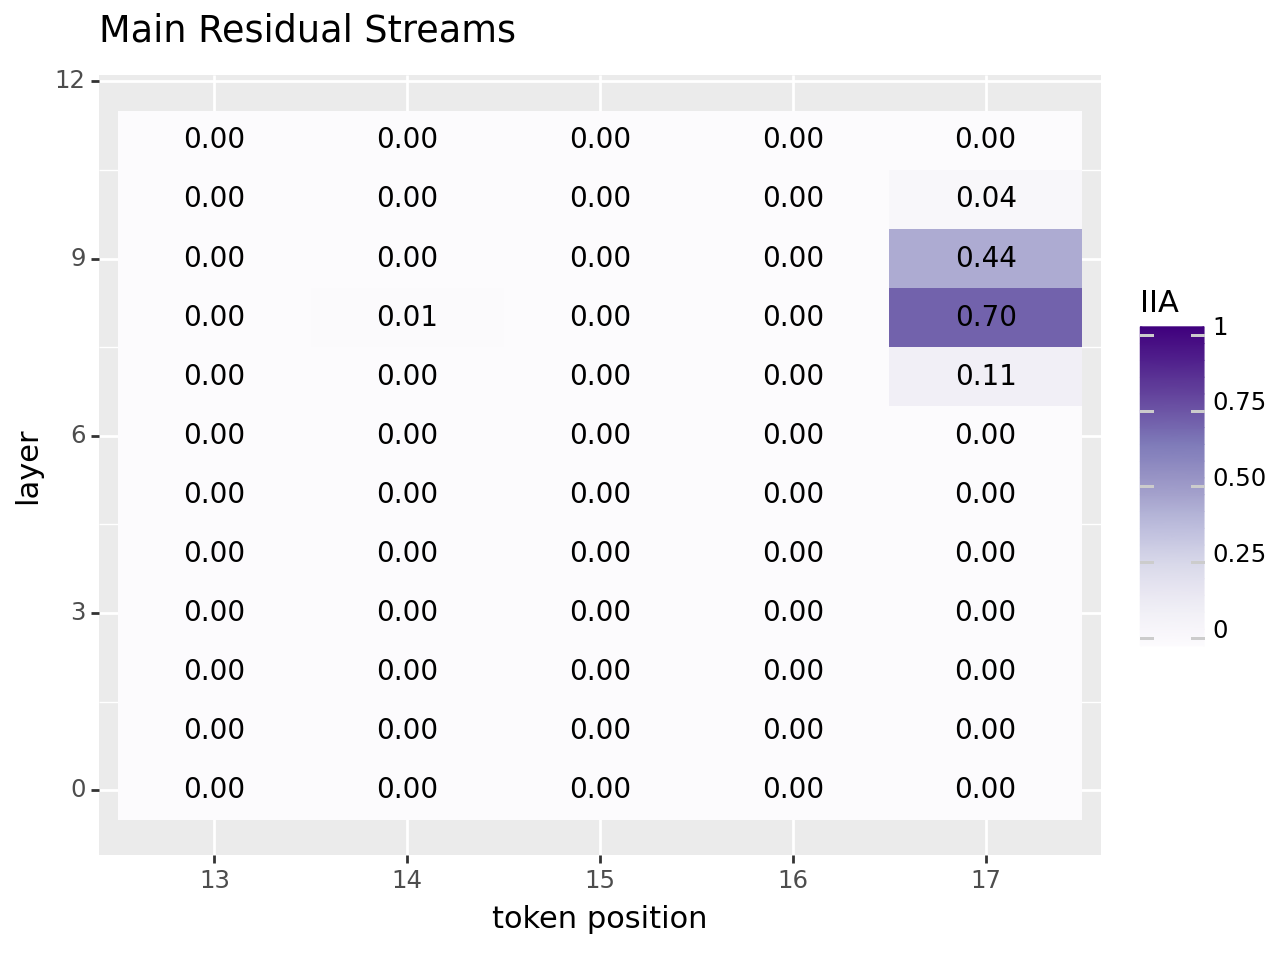

<Figure Size: (640 x 480)>

In [6]:
# df = pd.DataFrame(block_out_data)
# df.to_csv("./tutorial_data/block_out_df.csv")
df = pd.read_csv("./tutorial_data/block_out_df.csv")
df["layer"] = df["layer"].astype(int)
df["token position"] = df["pos"].astype(int)
df["IIA"] = df["acc"].astype(float)
df['token position'] = df['token position'].astype('category')

# Use format string to keep two decimal places
df["IIA_label"] = df["IIA"].apply(lambda x: f'{x:.2f}')

block_out_plot = (ggplot(df, aes(x="token position", y="layer"))
        + geom_tile(aes(fill="IIA")) + scale_fill_cmap("Purples", limits=[0,1])
        + geom_text(aes(label="IIA_label"), color="black", size=10) + ggtitle("Main Residual Streams"))
ggsave(block_out_plot, filename="./tutorial_data/block_out_plot.pdf", dpi=200)
block_out_plot

In [ ]:
mlp_activation_data = find_name_position_at(
    [13, 14, 15, 16, 17], [i for i in range(12)], "mlp_activation", debug=True)

/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6.4 x 4.8 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/mlp_activaiton_plot.pdf


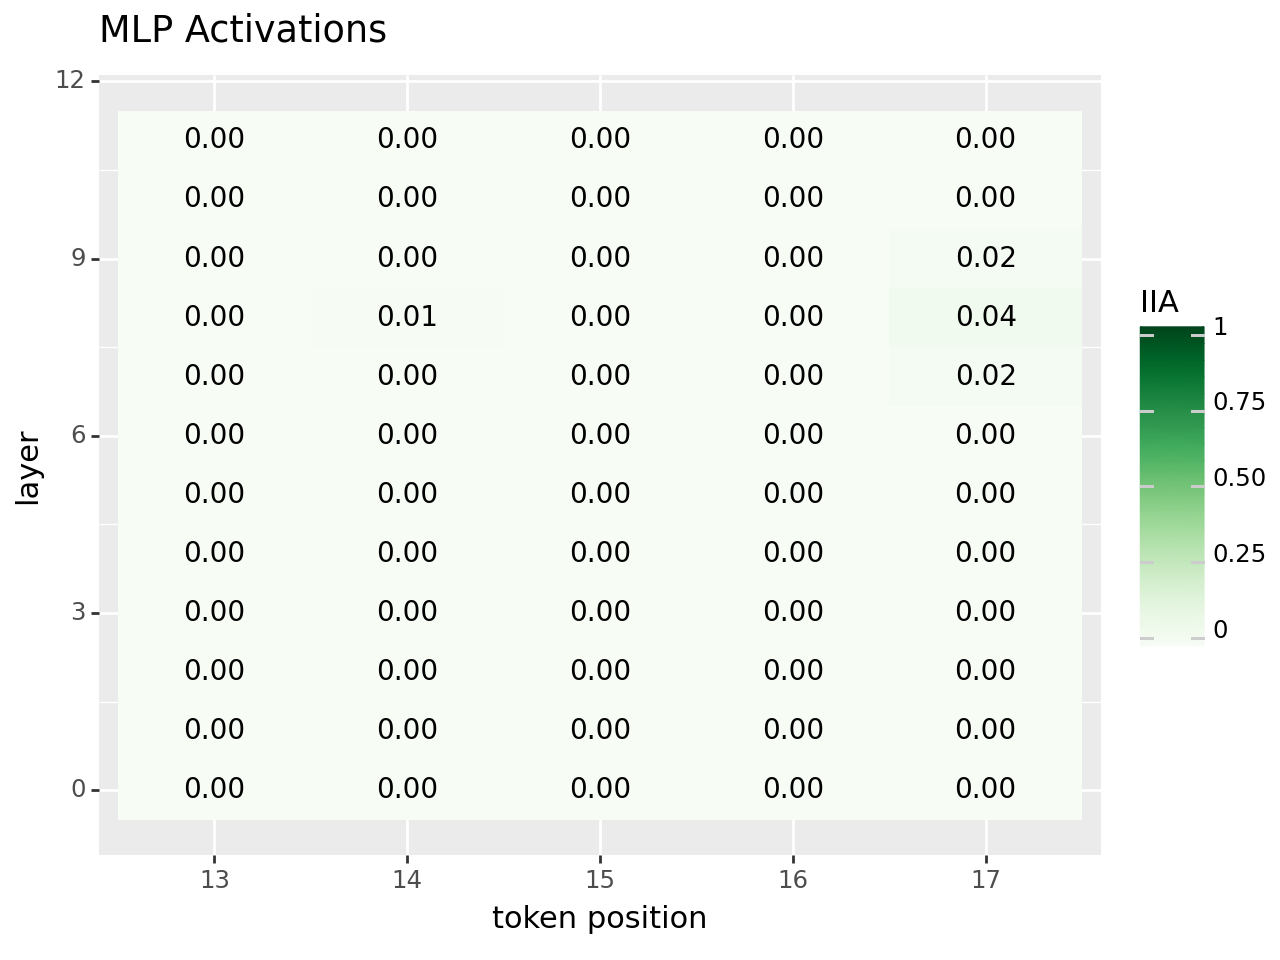

<Figure Size: (640 x 480)>

In [7]:
# df = pd.DataFrame(mlp_activation_data)
# df.to_csv("./tutorial_data/mlp_activation_df.csv")
df = pd.read_csv("./tutorial_data/mlp_activation_df.csv")
df["layer"] = df["layer"].astype(int)
df["token position"] = df["pos"].astype(int)
df["IIA"] = df["acc"].astype(float)
df['token position'] = df['token position'].astype('category')

# Use format string to keep two decimal places
df["IIA_label"] = df["IIA"].apply(lambda x: f'{x:.2f}')

mlp_activaiton_plot = (ggplot(df, aes(x="token position", y="layer"))
        + geom_tile(aes(fill="IIA")) + scale_fill_cmap("Greens", limits=[0,1])
        + geom_text(aes(label="IIA_label"), color="black", size=10) + ggtitle("MLP Activations"))
ggsave(mlp_activaiton_plot, filename="./tutorial_data/mlp_activaiton_plot.pdf", dpi=200)
mlp_activaiton_plot

### Localizing in across multiple tokens at layer 7, one layer earlier than layer 8

In [ ]:
proposals = []
for i in range(1, 19):
    proposal = []
    for j in range(i):
        proposal += [j]
    proposals += [proposal]

In [ ]:
block_out_across_tokens_data = find_name_position_at(
    [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]], [7], "block_output", debug=True)

### Localizing in different streams

In [ ]:
attn_input_data = find_name_position_at([17], [i for i in range(12)], "attention_input", debug=True)
block_input_data = find_name_position_at([17], [i for i in range(12)], "block_input", debug=True)
mlp_input_data = find_name_position_at([17], [i for i in range(12)], "mlp_input", debug=True)
mlp_act_data = find_name_position_at([17], [i for i in range(12)], "mlp_activation", debug=True)
attn_out_data = find_name_position_at([17], [i for i in range(12)], "attention_output", debug=True)
mlp_out_data = find_name_position_at([17], [i for i in range(12)], "mlp_output", debug=True)
attn_value_out_data = find_name_position_at([17], [i for i in range(12)], "attention_value_output", debug=True)
block_output_data = find_name_position_at([17], [i for i in range(12)], "block_output", debug=True)

/tmp/wuzhengx/ipykernel_3479713/4249182280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/wuzhengx/ipykernel_3479713/4249182280.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/all_mlp_locations_plot.pdf


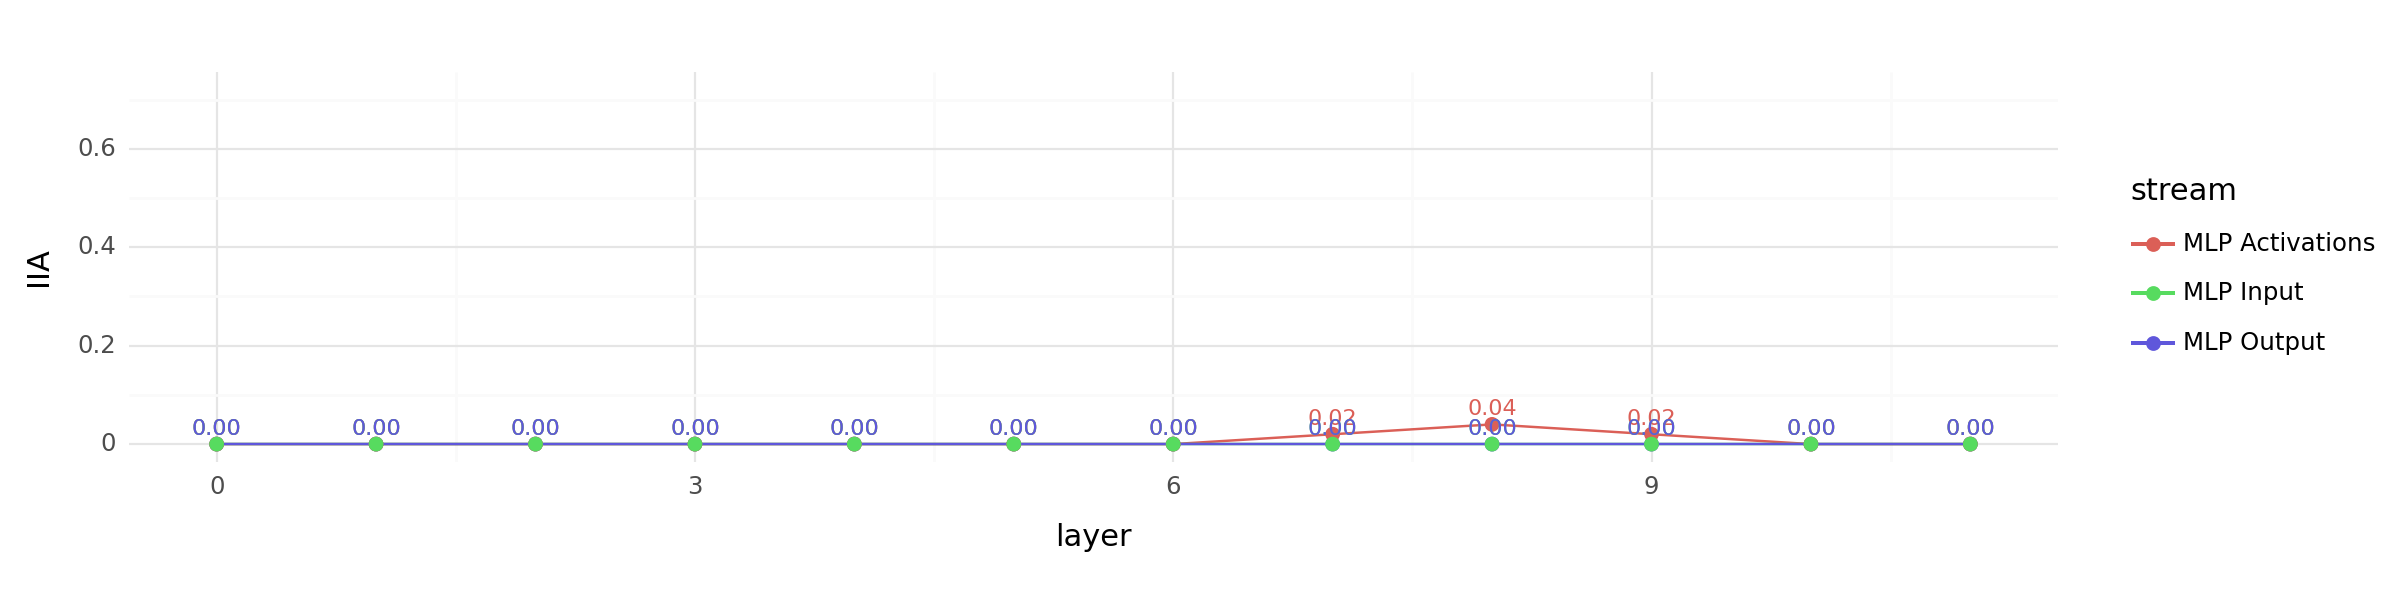

<Figure Size: (1200 x 300)>

In [8]:
# all_streams_df = pd.DataFrame(
#     block_output_data+attn_out_data+mlp_out_data+attn_value_out_data+mlp_act_data+mlp_input_data+block_input_data+attn_input_data
# )
# all_streams_df.to_csv("./tutorial_data/all_streams_df.csv")
all_streams_df = pd.read_csv("./tutorial_data/all_streams_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[all_streams_df['stream'].isin({"mlp_output", "mlp_input", "mlp_activation"})]
stream_labels = {"mlp_output": "MLP Output", "mlp_input": "MLP Input", "mlp_activation": "MLP Activations"}
df["stream"] = df["stream"].replace(stream_labels)
def custom_format(x):
    return f"{x:.2f}"
df['IIA_formatted'] = df['IIA'].apply(custom_format)
all_mlp_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream")) +
    geom_line() +
    geom_point(size=2) +
    geom_text(aes(label='IIA_formatted'), nudge_y=0.01, size=8, va='bottom', show_legend=False) +
    theme_minimal() +
    ylim(0, 0.72) +
    theme(
        figure_size=(12, 3)
    )
)

ggsave(all_mlp_locations_plot, filename="./tutorial_data/all_mlp_locations_plot.pdf", dpi=200)
all_mlp_locations_plot

/tmp/wuzhengx/ipykernel_3479713/1577052243.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/wuzhengx/ipykernel_3479713/1577052243.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 12 x 3 in image.
/u/nlp/anaconda/main/anaconda3/envs/wuzhengx-bootleg/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ./tutorial_data/other_locations_plot.pdf


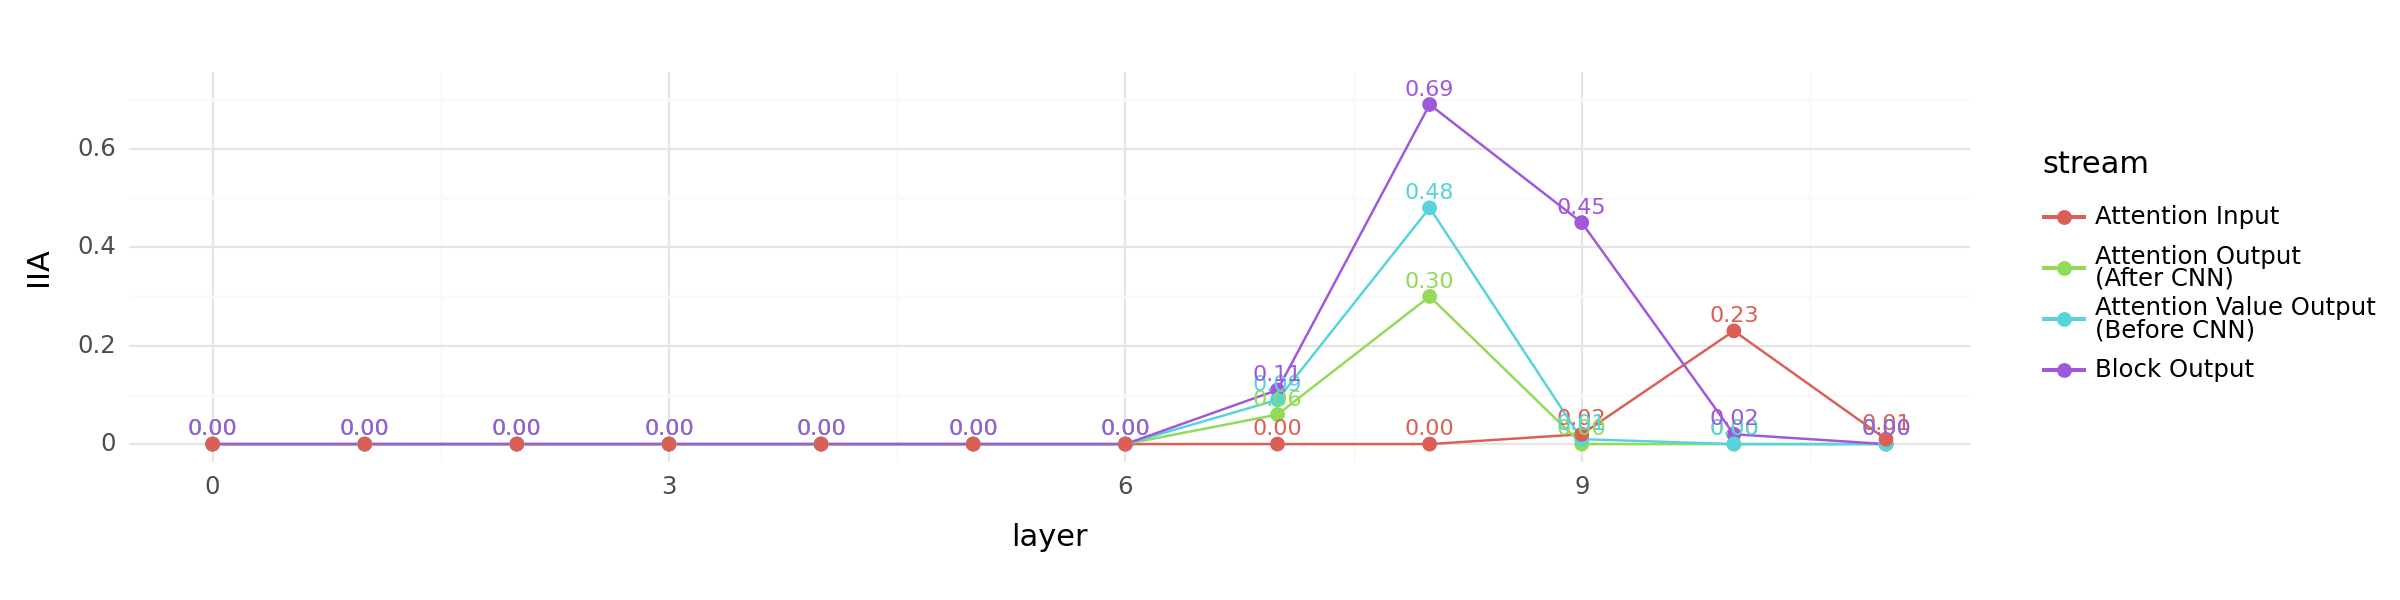

<Figure Size: (1200 x 300)>

In [9]:
all_streams_df = pd.read_csv("./tutorial_data/all_streams_df.csv")
all_streams_df["IIA"] = all_streams_df["acc"]
df = all_streams_df[all_streams_df['stream'].isin({
    "block_output", "attention_input", 
    "attention_output", "attention_value_output"
})]
stream_labels = {
    "block_output": "Block Output", 
    "attention_input": "Attention Input", 
    "attention_output": "Attention Output\n(After CNN)", 
    "attention_value_output": "Attention Value Output\n(Before CNN)"
}
df["stream"] = df["stream"].replace(stream_labels)
def custom_format(x):
    return f"{x:.2f}"
df['IIA_formatted'] = df['IIA'].apply(custom_format)
other_locations_plot = (
    ggplot(df, aes(x="layer", y="IIA", color="stream")) +
    geom_line() +
    geom_point(size=2) +
    geom_text(aes(label='IIA_formatted'), nudge_y=0.01, size=8, va='bottom', show_legend=False) +
    theme_minimal() +
    ylim(0, 0.72) +
    theme(
        figure_size=(12, 3)
    )
)

ggsave(other_locations_plot, filename="./tutorial_data/other_locations_plot.pdf", dpi=200)
other_locations_plot

### Localizing in each individual head at layer 7 and 8

In [ ]:
head_attn_value_out_data = []
for h in range(12):
    _head_attn_value_out_data = find_name_position_at(
        [17], [7, 8], "head_attention_value_output", [h])
    head_attn_value_out_data.extend(_head_attn_value_out_data)

In [ ]:
df = pd.DataFrame(head_attn_value_out_data)

plot = (
    ggplot(df, aes(x="layer", y="acc", color="stream")) +
    geom_line() +
    geom_point(size=2) +
    theme_minimal() +
    ylim(0, 1)
)

print(plot)

### Localizing with group of heads using rankings of missing out head IIA

In [ ]:
layer = 7

head_attn_value_out_mo_data = []
for i in range(12):
    print("evaluating grouped IIA without head", i)
    _head_attn_value_out_mo_data = find_name_position_at(
        [17], [layer], "head_attention_value_output", 
        heads=list(set([i for i in range(12)]) - {i})
    )[0]
    _head_attn_value_out_mo_data["mo_head"] = i
    head_attn_value_out_mo_data += [_head_attn_value_out_mo_data]

In [163]:
head_rank_list = []
anchor_acc = 0.48
for data in head_attn_value_out_mo_data:
    head_rank_list += [(data['mo_head'], anchor_acc-data['acc'])]
head_rank_list = sorted(head_rank_list, key=lambda x: x[1], reverse=True)

In [ ]:
df = pd.DataFrame(head_attn_value_out_mo_data)
df['mo_head_cat'] = pd.Categorical(df['mo_head'], categories=df['mo_head'].unique(), ordered=True)
head_drop_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head")) +
    geom_bar(stat="identity", position="dodge", width=0.9) +
    labs(x=f"Leave-One-Out (LOO) Head Index ({layer}th Layer)", y="IIA") +  # Add axis labels
    theme_minimal() + # Use a minimal theme
    theme(
        figure_size=(10, 2)
    ) +
    theme(legend_position='none') + 
    scale_x_discrete(labels=[f"head {i}" for i in df['mo_head']])
)

ggsave(head_drop_plot, filename=f"./tutorial_data/layer_{layer}_head_drop_plot.pdf", dpi=200)
head_drop_plot

In [ ]:
head_attn_value_out_cumulative_data = []
current_heads = []
for i in head_rank_list:
    current_heads += [i[0]]
    print("evaluating grouped IIA adding head", i[0])
    _head_attn_value_out_cumulative_data = find_name_position_at(
        [17], [layer], "head_attention_value_output", 
        heads=current_heads
    )[0]
    _head_attn_value_out_cumulative_data["adding_head"] = i[0]
    head_attn_value_out_cumulative_data += [_head_attn_value_out_cumulative_data]

In [ ]:
df = pd.DataFrame(head_attn_value_out_cumulative_data)
df['adding_head_cat'] = pd.Categorical(df['adding_head'], categories=df['adding_head'].unique(), ordered=True)

head_acc_plot = (
    ggplot(df, aes(x="adding_head_cat", y="acc", fill="adding_head")) +
    geom_bar(stat="identity", position="dodge", width=0.9) +
    labs(x=f"Cumulative Head Index ({layer}th Layer)", y="IIA") +  # Add axis labels
    theme_minimal() + # Use a minimal theme
    theme(
        figure_size=(10, 2)
    ) +
    theme(legend_position='none') + 
    scale_x_discrete(labels=[f"+ head {i}" for i in df['adding_head']])
)

ggsave(head_acc_plot, filename=f"./tutorial_data/layer_{layer}_head_acc_plot.pdf", dpi=200)
head_acc_plot

### Layer 10 name position information access from head

In [ ]:
head_query_output_mo_data = []
for i in range(12):
    _head_query_output_mo_data = find_name_position_at(
        [17], [10], "head_query_output", 
        heads=list(set([i for i in range(12)]) - {i}),
        debug=True
    )
    _head_query_output_mo_data["mo_head"] = i
    head_query_output_mo_data.extend(_head_query_output_mo_data)

In [ ]:
df = pd.DataFrame(head_query_output_mo_data)
df['mo_head_cat'] = pd.Categorical(df['mo_head'], categories=df['mo_head'].unique(), ordered=True)
mover_head_drop_plot = (
    ggplot(df, aes(x="mo_head_cat", y="acc", fill="mo_head")) +
    geom_bar(stat="identity", position="dodge", width=0.9) +
    labs(x=f"Leave-One-Out (LOO) Head Index (10th Layer)", y="IIA") +  # Add axis labels
    theme_minimal() + # Use a minimal theme
    theme(
        figure_size=(10, 2)
    ) +
    theme(legend_position='none') + 
    scale_x_discrete(labels=[f"head {i}" for i in df['mo_head']])
)

ggsave(mover_head_drop_plot, filename=f"./tutorial_data/layer_10_mover_head_drop_plot.pdf", dpi=200)
mover_head_drop_plot

### Skip layer to prune computations

In [253]:
skip_layers = [10,11]
skip_component = "block_output"
skip_tokens = [i for i in range(18)]

In [254]:
alignable_config = AlignableConfig(
    alignable_model_type=type(gpt2),
    alignable_representations=[
        AlignableRepresentationConfig(
            skip_layer,
            skip_component,
            "pos",
            len(skip_tokens),
        ) for skip_layer in skip_layers
    ],
    alignable_interventions_type=SkipIntervention,
    mode="serial"
)
alignable = AlignableModel(alignable_config, gpt2)
alignable.set_device("cuda")
alignable.disable_model_gradients()

In [255]:
total_count = 0
correct_count = 0
with torch.no_grad():
    for batch_dataset in D_train.batches(batch_size=30):
        inputs = batch_dataset.base.tokens
        
        for k, v in inputs.items():
            if v is not None and isinstance(v, torch.Tensor):
                inputs[k] = v.to(gpt2.device)
        labels = batch_dataset.base.answer_tokens[:,0].to(gpt2.device)
        b_s = inputs["input_ids"].shape[0]
        
        sources_input = {}
        for i in range(len(skip_layers)-1):
            sources_input[f"source_{i}->source_{i+1}"] = ([[skip_tokens]*b_s], [[skip_tokens]*b_s])
        sources_input[f"source_{len(skip_layers)-1}->base"] = ([[skip_tokens]*b_s], [[skip_tokens]*b_s])
        _, outputs = alignable(
            {"input_ids": inputs["input_ids"]},
            [{"input_ids": inputs["input_ids"]} for _ in range(len(skip_layers))],
            sources_input
        )

        pred_labels = outputs.logits.argmax(dim=-1)[:,-1]
        correct_labels = (labels==pred_labels)

        total_count += len(correct_labels)
        correct_count += correct_labels.sum().tolist()
current_acc = round(correct_count/total_count, 2)
print(f"pruned gpt-2 IOI task accuracy: {current_acc}")

pruned gpt-2 IOI task accuracy: 0.93
